# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [22]:
import numpy as np
import math 
import random
import matplotlib.pyplot as plt

# NOTES
# TODO show that the train test creation is really random, i.e that every class has 1/3 chance of being the majority class over all the dataset
# TODO make doxygen-like comments ?
# TODO confirm the experimental results with theoretical results
# TODO not sure normalization is needed for the features ?
# TODO weighting the closest points ?
# TODO improve calculations by using linear algebra 
# TODO calculate variance and std to know the right number of folds
# TODO fix the random seed ?

## Loading Data

In [23]:
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

features = normalization(feat_to_norm=features)    

labels = np.array(data[:,data.shape[1]-1:])

###  Creating the dataset in python

In [68]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)

    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

print("Training set : "+str(x_train.shape[0])+" examples.\nTest set : "+str(x_test.shape[0])+" examples.")
nb_classes_train = np.unique(y_train, return_counts=True)
nb_classes_test = np.unique(y_test, return_counts=True)
print("Distribution of classes for the Training set : ")
print(nb_classes_train[0])
print(nb_classes_train[1])
print("Distribution of classes for the Test set : ")
print(nb_classes_test[0])
print(nb_classes_test[1])

Training set : 4000 examples.
Test set : 1000 examples.
Distribution of classes for the Training set : 
[0. 1. 2.]
[1325 1325 1350]
Distribution of classes for the Test set : 
[0. 1. 2.]
[332 322 346]


### Various functions

In [25]:
# Returns the euclidian distance between the vectors x1 and x2
def euclidian_distance(x1, x2):
    assert len(x1) == len(x2), "Dimensions of x1 and x2 must be the same"

    return np.sqrt(np.sum((x2 - x1) ** 2))

# Returns an array with the distances from x to every x' in x_array
def distance_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1).reshape(-1, 1)

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total

## KNN Algorithm

In [26]:
# Returns the majority class from the features amongst the k nearest neighbors of new_input 
def knn(new_input, features, labels, k):
    # Computing the distance from new_input to every x in features
    dist_array = distance_array(new_input, features)

    # Associating the distance array with their corresponding labels
    dist_array_labeled = np.hstack([dist_array, labels])

    # Sorting the array by increasing distance order (keeping the labels associated)
    sorted_indices = np.argsort(dist_array_labeled[:, 0])
    sorted_array = dist_array_labeled[sorted_indices]

    # Count the number of occurences of each class Yj among the k nearest neighbors
    label, counts = np.unique(sorted_array[:k, 1], return_counts=True, axis=0)
    results = dict(zip(label, counts))

    # Returning the majority class among the k nearest neighbors
    majority_class = max(results, key=results.get)
    return majority_class

# Returns the accuracy of the prediction over the entire x_set for k nearest neighbors
def prediction(x_set, y_set, k):
    right_predictions = 0
    total_predictions = len(x_set)

    classes = np.unique(y_set)
    nb_classes = len(classes)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    for i in range(total_predictions) :
        # Take the example predicted out as we don't want his class taken into account
        new_x_train = np.delete(x_set, i, axis=0)
        new_y_train = np.delete(y_set, i, axis=0)

        y_pred = knn(x_set[i], new_x_train, new_y_train, k)
        y_actual = y_set[i, 0]

        if (y_pred == y_actual):
            right_predictions +=1

        index_pred = np.where(classes == y_pred)[0][0]
        index_actual = np.where(classes == y_actual)[0][0]
        confusion_matrix[index_actual, index_pred] += 1


    accuracy = (right_predictions * 100) / total_predictions
    return accuracy, confusion_matrix


## Tuning k by cross-validation

In [69]:
#Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

# Returns the metrics for a given k using cross-validation
def cross_validation(k, x_train_folds, y_train_folds, nb_folds):
    fold_accuracies = []
    fold_confusion_matrices = []

    for n in range(nb_folds):
        x_val_fold = x_train_folds[n]
        y_val_fold = y_train_folds[n]

        fold_accuracy, fold_cm = (prediction(x_val_fold, y_val_fold, k))
        fold_accuracies.append(fold_accuracy)
        fold_confusion_matrices.append(fold_cm)

    print("Validation folds accuracies :"+str(fold_accuracies))
    mean_accuracy = np.mean(fold_accuracies)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
    return mean_accuracy, mean_confusion_matrix


nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)
k_range = range(1, 100)
accuracies = []
confusion_matrices = []

for k in k_range : 
    mean_acc, mean_cm = cross_validation(k, x_subsets, y_subsets, nb_folds)

    accuracies.append(mean_acc)  
    confusion_matrices.append(mean_cm)
    print("k = "+str(k)+" mean accuracy = "+str(mean_acc))
    print("Confusion Matrix : \n"+str(mean_cm))


Validation folds accuracies :[75.75, 75.75, 71.25, 76.25, 77.375]
k = 1 mean accuracy = 75.275
Confusion Matrix : 
[[182.   44.   39. ]
 [ 34.2 209.6  21.2]
 [ 34.6  24.8 210.6]]
Validation folds accuracies :[73.875, 76.5, 69.25, 75.25, 75.875]
k = 2 mean accuracy = 74.15
Confusion Matrix : 
[[223.   21.8  20.2]
 [ 57.2 197.8  10. ]
 [ 57.8  39.8 172.4]]
Validation folds accuracies :[79.5, 80.0, 74.25, 81.75, 78.0]
k = 3 mean accuracy = 78.7
Confusion Matrix : 
[[186.8  40.   38.2]
 [ 27.4 217.6  20. ]
 [ 25.4  19.4 225.2]]
Validation folds accuracies :[78.375, 80.375, 74.125, 80.5, 79.375]
k = 4 mean accuracy = 78.55
Confusion Matrix : 
[[216.4  25.6  23. ]
 [ 42.2 212.4  10.4]
 [ 43.2  27.2 199.6]]
Validation folds accuracies :[79.5, 81.0, 77.0, 83.0, 81.0]
k = 5 mean accuracy = 80.3
Confusion Matrix : 
[[190.   37.8  37.2]
 [ 25.8 222.   17.2]
 [ 23.8  15.8 230.4]]
Validation folds accuracies :[79.375, 81.5, 77.5, 82.625, 80.75]
k = 6 mean accuracy = 80.35
Confusion Matrix : 
[[209.

### Plotting of the accuracies w.r.t k

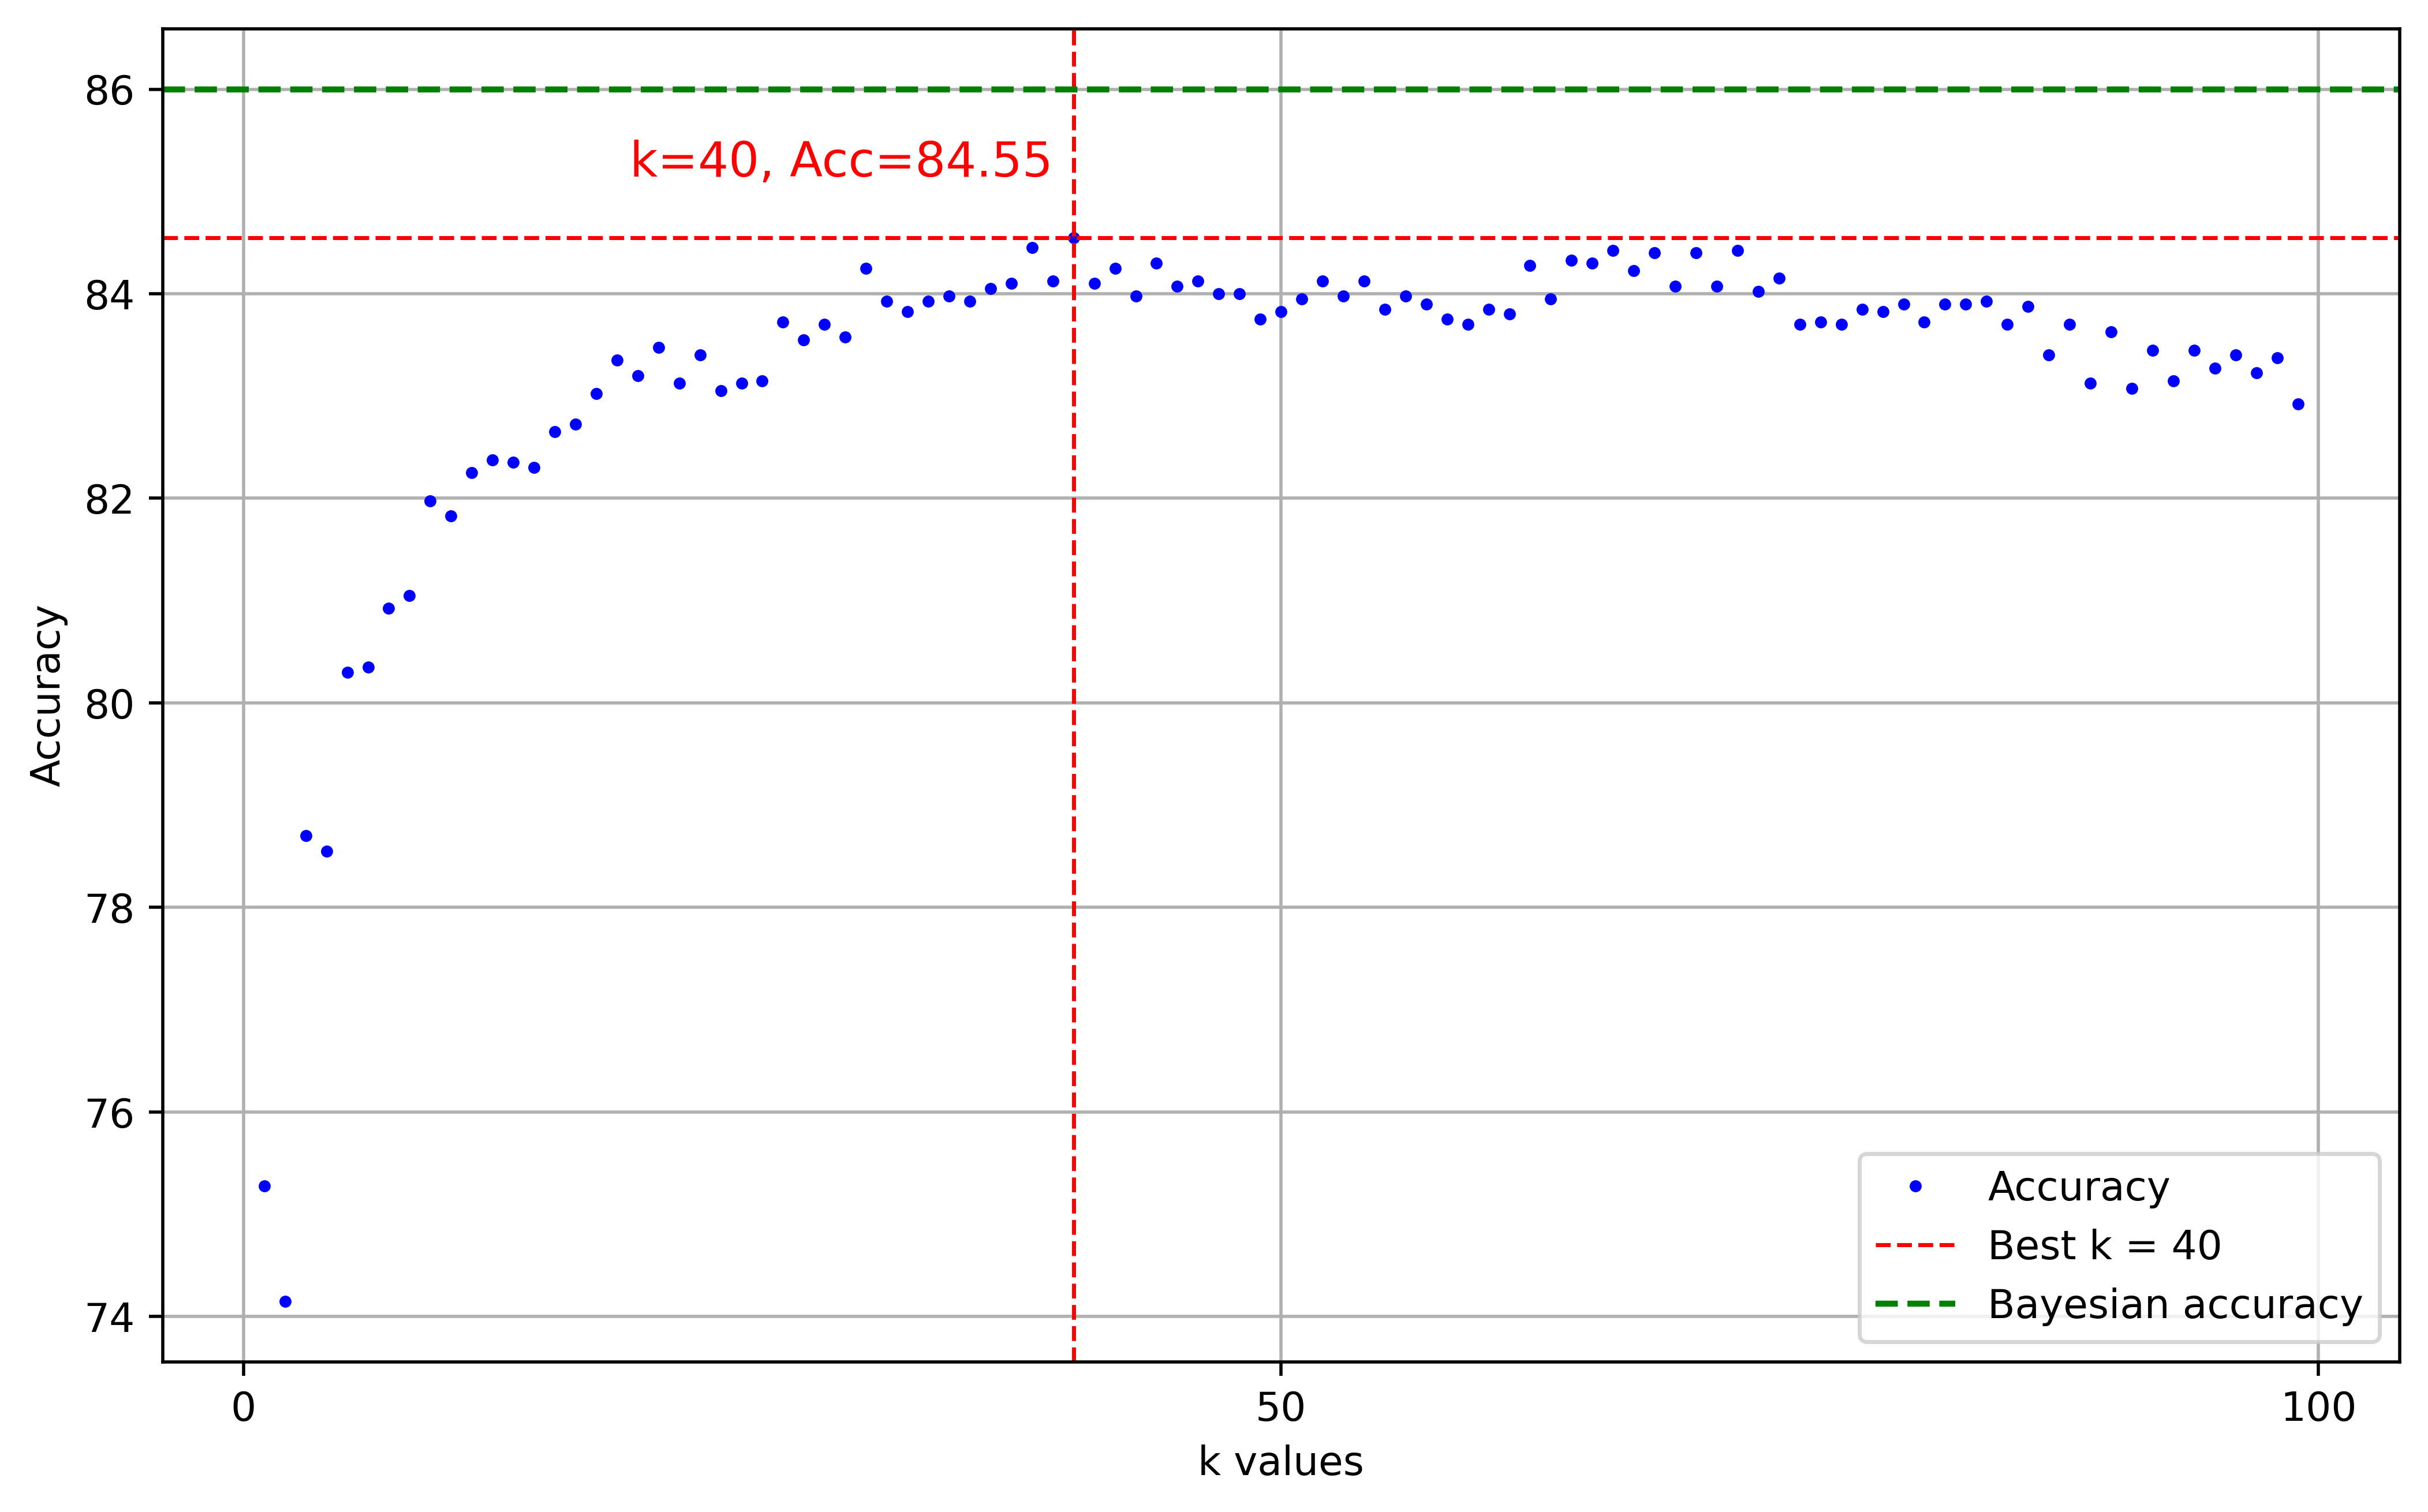

In [71]:
max_accuracy = max(accuracies)
best_k = k_range[accuracies.index(max_accuracy)] 

plt.figure(figsize=(10, 6), dpi=500) 
plt.plot(k_range, accuracies, label='Accuracy', marker='o', color='b',markersize=2,linestyle='None')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
plt.axhline(y=max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(best_k-1, max_accuracy+.5, f'k={best_k}, Acc={max_accuracy:.2f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 50)) 
plt.grid(True)
plt.legend()
plt.show()


### Confusion matrix of the best k

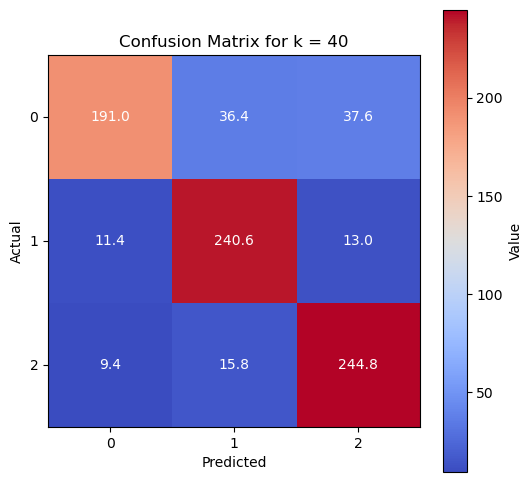

In [72]:

confusion_mat_best_k = confusion_matrices[accuracies.index(max_accuracy)]
plt.figure(figsize=(6, 6))
plt.imshow(confusion_mat_best_k, cmap='coolwarm')
plt.colorbar(label='Value')

for (i, j), value in np.ndenumerate(confusion_mat_best_k):
    plt.text(j, i, f'{value}', ha='center', va='center', color='white')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for k = '+str(best_k))
plt.xticks(np.arange(confusion_mat_best_k.shape[1]), ['0', '1', '2'])
plt.yticks(np.arange(confusion_mat_best_k.shape[0]), ['0', '1', '2'])
plt.show()


In [30]:
#test prediction sur test set
print(prediction(x_test, y_test, best_k))

(83.8, array([[266.,  43.,  37.],
       [ 20., 300.,  15.],
       [ 21.,  26., 272.]]))
